In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import numpy as np
from IPython.display import display, Image

In [53]:
# read in data about the 800 season passholders
passholders = pd.read_csv("/Users/jiunlee/Documents/Fall_23/MarketingAnalytics/Assignment2/passholders23.csv")

# Part I: Segmentation 

### A. Drop the passholderID variable

In [54]:
# A. Drop the passholderID variable
passholders.drop("passholderID", axis=1, inplace=True)

a. Why will passholderID not be relevant in a clustering model? 
- The clustering model uses Euclidean distance to group similar observations. The 'passholderID" variable doesn't represent a quantitative value, it's categorical variable that can be used for indexes of each observation(passholders). When we use this variable in clustering model, the model will calculate the Euclidean distancepoints based on the un-quantitative data points, leading to misleading clusters.

### B

In [55]:
# B. Call the describe() function on your dataset
passholders.describe()

,visits23,ride_avg,game_spend_avg,avg_duration,inquiries_365,discounts_23,merch_spend_average,online_spend_average,food_spend_average
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,5.857500,5.052375,18.855750,235.569875,3.936250,2.948750,14.934625,24.013750,19.058875
std,2.465724,1.959060,4.028328,101.832402,2.004922,1.725499,2.163230,1.158064,3.100098
min,1.000000,-1.600000,6.000000,60.400000,0.000000,0.000000,8.200000,21.200000,9.400000
25%,4.000000,3.800000,16.200000,146.875000,2.000000,2.000000,13.400000,23.200000,17.075000
50%,6.000000,5.100000,18.800000,240.350000,4.000000,3.000000,14.900000,24.000000,19.100000
75%,7.000000,6.400000,21.400000,320.175000,5.000000,4.000000,16.400000,24.900000,21.100000
max,15.000000,11.400000,33.000000,410.000000,15.000000,11.000000,21.400000,28.800000,29.200000


a. How does this function help you to gain an overall sense of the columns
and values in this (or any other) dataset? Why is this valuable for any
analyst who will use a dataset to build a model?

- This is valuable for data analysts because it helps them to get an overall understanding of the data by offering basic statistics for each variable in the dataset. Those statistics values are useful to identify the distribution of each variable, making it easy to detect outliers in each column. In conclusion, this pre-step of data analysis is necessary to lay the groundwork before building a model.

### C

In [56]:
# C. Missing values/impossible values
passholders.isnull().sum()

visits23                0
ride_avg                0
game_spend_avg          0
avg_duration            0
inquiries_365           0
discounts_23            0
merch_spend_average     0
online_spend_average    0
food_spend_average      0
dtype: int64

a.
There is no missing values in this dataset.

b.
We could confirm `ride_avg` column's min value is -1.600000	from describe() function. This is impossible value. Since values under zero represents the very low average number of rides taken, we can impute them as zero.

In [57]:
#b. impossible value handling
passholders[passholders['ride_avg'] <0] #confirm the values under zero.

,visits23,ride_avg,game_spend_avg,avg_duration,inquiries_365,discounts_23,merch_spend_average,online_spend_average,food_spend_average
80,3,-0.1,19.4,216.5,2,1,14.5,25.0,27.9
319,6,-0.4,14.9,300.6,7,3,12.2,23.4,18.2
509,7,-0.9,16.2,287.6,6,2,15.5,24.8,17.8
510,7,-1.6,22.0,304.2,6,3,12.1,23.2,19.7
532,5,-0.1,13.9,333.7,2,1,17.1,25.8,21.6


In [58]:
#b. imputing with zero
passholders.loc[passholders['ride_avg'] < 0, 'ride_avg'] = 0 # imputing with zero
passholders[passholders['ride_avg'] <0] #confirm the values under zero. No negative values anymore!

,visits23,ride_avg,game_spend_avg,avg_duration,inquiries_365,discounts_23,merch_spend_average,online_spend_average,food_spend_average


### D. Data scaling

a. We have to standardize the variables because their scales are too different. The variables for money spending, ride_avg, and visits23 are all on different scales. Standardization is necessary to prevent variables with large scale from having strong influence on the model.

In [59]:
#b
scaler = StandardScaler()
scaler.fit(passholders)
passholders_standardized = scaler.transform(passholders)
passholders_standardized= pd.DataFrame(data=passholders_standardized, index=passholders.index, columns=passholders.columns)
passholders_standardized.head()

,visits23,ride_avg,game_spend_avg,avg_duration,inquiries_365,discounts_23,merch_spend_average,online_spend_average,food_spend_average
0,-1.159614,0.382063,-1.007437,-1.043246,-0.966353,0.029720,-0.617345,0.420144,-0.567716
1,0.463643,0.536173,-0.411284,0.915115,1.529071,0.029720,-0.432321,1.111385,-0.535439
2,0.463643,-0.080265,-0.783880,1.415269,0.031817,-1.130090,-0.709858,0.592955,-0.470884
3,-1.971242,-0.285745,1.948490,0.118210,-0.467268,3.509151,-0.802370,-1.135146,1.013868
4,-1.159614,-1.210402,-0.634841,-1.505078,-0.467268,-1.709996,-0.802370,-0.703121,-0.987320


### E. Variable selection. Select any 5 variables from the potential set of inputs in order to build your k-means clustering model.

In [60]:
passholders.columns

Index(['visits23', 'ride_avg', 'game_spend_avg', 'avg_duration',
       'inquiries_365', 'discounts_23', 'merch_spend_average',
       'online_spend_average', 'food_spend_average'],
      dtype='object')

E. a. The variables that I've selected: `visits23`, `ride_avg`, `game_spend_avg`, `merch_spend_average`, `food_spend_average`. Visits23 could be correlated with levels of enthusiasm; someone people are amusement park maniacs and others only came once a year. There is a clear distinction here in terms of groups. On the other hand, I selected four variables correlated with spending because I believe that this is where you can distinctify groups the most. Similar to the visit23 variable, you can very much separate groups based on their spending, because characteristics of people can be seen through their spending habits. Perhaps, younger people are likely to spend more, and adults are more less to spend less. Either way, groups can easily be distinguished through these habits. 

In [61]:
#subset the selected variables before clustering
passholders_std_subset=passholders_standardized[['visits23','game_spend_avg','merch_spend_average','ride_avg','food_spend_average']]

### F. Elbow chart.

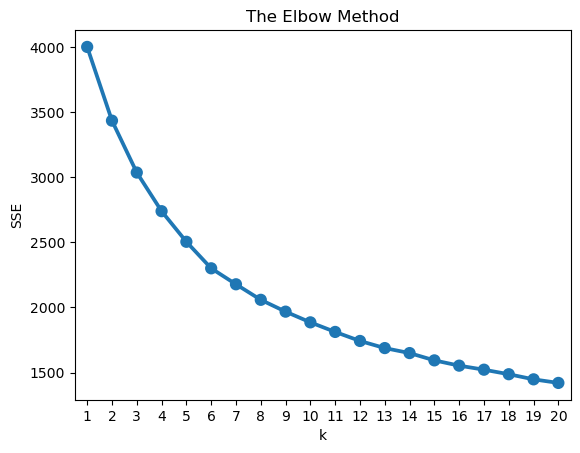

In [62]:
sse = {}
for k in range(1, 21):
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=345)
    # Fit KMeans on the normalized dataset
    kmeans.fit(passholders_std_subset)
    sse[k] = kmeans.inertia_

# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')
# Add X-axis label "k"
plt.xlabel('k')
# Add Y-axis label "SSE"
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()));

### G. How many clusters will you use for your k-means model? 

It's hard to decide because the curve of the elbow is very subtle, but the range between 5-7 looks the best, I would choose K= 6.

### H. Build a k-means model with your desired number of clusters.

In [63]:
#Clustering K=5
kmeans = KMeans(n_clusters=6, random_state=45)
kmeans.fit(passholders_std_subset)

KMeans(n_clusters=6, random_state=45)

### I. Generate and show summary statistics about each of your clusters.

In [64]:
# Adding the cluster labels to the original dataset(unstandardized)
cluster_labels = kmeans.labels_ #cluster labels for each observation
passholders_kmeans = passholders.assign(Cluster = cluster_labels) #original dataset with cluster label column
passholders_kmeans['Cluster'] = passholders_kmeans['Cluster'].astype('category')


# Grouping by the cluster labels and generating summary statistics
cluster_summary = passholders_kmeans.groupby('Cluster').describe()

print(cluster_summary)


        visits23                                                ride_avg  \
           count      mean       std  min  25%  50%   75%   max    count   
Cluster                                                                    
0          138.0  6.260870  1.888514  2.0  5.0  6.0   8.0  11.0    138.0   
1          114.0  9.728070  1.720697  7.0  8.0  9.0  11.0  15.0    114.0   
2          121.0  4.586777  1.833346  1.0  3.0  4.0   6.0   8.0    121.0   
3          133.0  5.646617  1.875663  1.0  4.0  6.0   7.0  10.0    133.0   
4          167.0  4.964072  1.703618  1.0  4.0  5.0   6.0   8.0    167.0   
5          127.0  4.551181  1.789336  1.0  3.0  4.0   6.0   9.0    127.0   

                   ... online_spend_average       food_spend_average  \
             mean  ...                  75%   max              count   
Cluster            ...                                                 
0        5.765217  ...               24.700  26.7              138.0   
1        4.419298  ...     

### J. Build any four simple visualizations to help management better understand your clusters 

Text(0, 0.5, 'Game Spend Average')

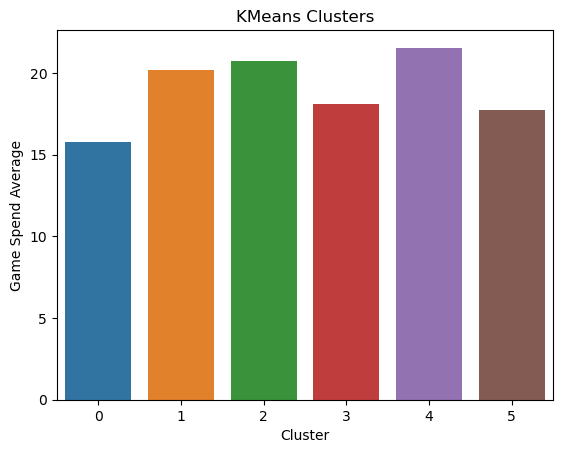

In [65]:
sns.barplot(x='Cluster', y='food_spend_average', data=passholders_kmeans, ci=None)
plt.title('KMeans Clusters')
plt.ylabel('Game Spend Average')

This plot shows the average spending money on food for each cluster. The difference in the average money spent on food is not too much for each cluster.

<AxesSubplot:xlabel='ride_avg', ylabel='Count'>

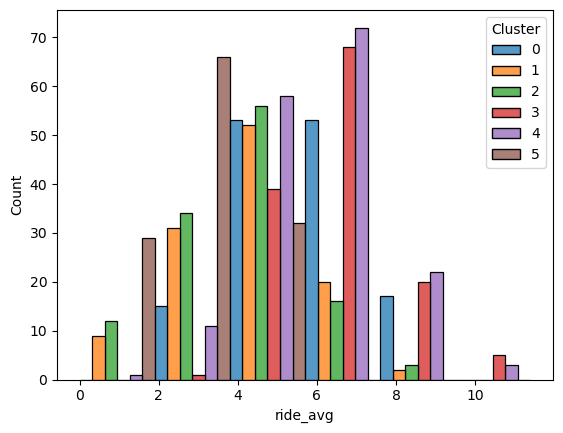

In [66]:
sns.histplot(data=passholders_kmeans, x="ride_avg", hue="Cluster", multiple='dodge',bins=6)

This plot is a dodged histogram where the y-axis shows the count of the average number of rides taken per visit for each cluster. It seems like Cluster 4 tends to take the rides more than Cluster 5.

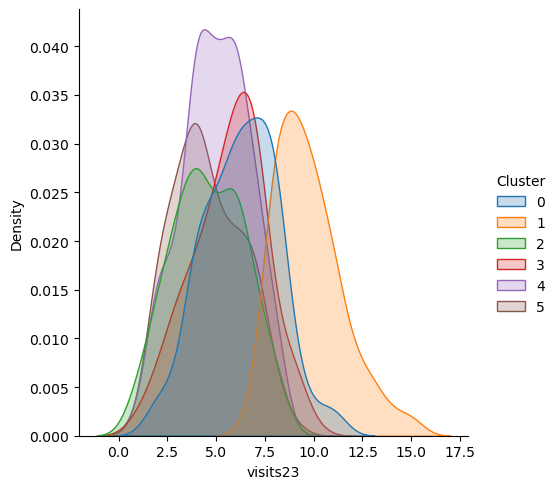

In [67]:
sns.displot(passholders_kmeans, x="visits23", hue="Cluster", kind='kde', fill=True)

The distribution of 6 clusters has clear differences from each other. It seems like Cluster 1 has a higher number of visitors among the 6 clusters.

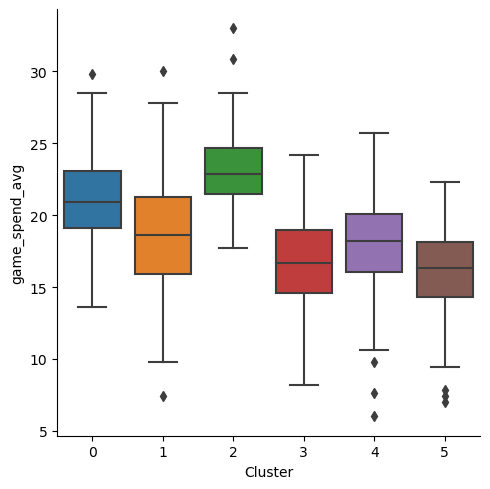

In [68]:
sns.catplot(x="Cluster", y="game_spend_avg", kind="box", data=passholders_kmeans);

Box plot offers a direct understanding of distributions. Cluster 2 spends more money on games than any other cluster.

### K. Give a descriptive name to each one of your clusters, along with a few sentences of explanation for the name that you chose.

In [69]:
#cluster_summary = passholders_kmeans.groupby('Cluster').mean()[['visits23','game_spend_avg','merch_spend_average','ride_avg','food_spend_average']]
#cluster_summary

cluster_summary = passholders_kmeans.groupby('Cluster').mean()
cluster_summary



,visits23,ride_avg,game_spend_avg,avg_duration,inquiries_365,discounts_23,merch_spend_average,online_spend_average,food_spend_average
Cluster,,,,,,,,,
0,6.260870,5.765217,21.129710,240.632609,3.862319,3.036232,16.126087,23.981884,15.764493
1,9.728070,4.419298,18.594737,246.842105,3.903509,3.052632,14.822807,24.095614,20.200877
2,4.586777,4.201653,23.307438,220.387603,3.793388,2.719008,13.751240,23.936364,20.711570
3,5.646617,6.520301,16.687218,232.621053,4.037594,2.894737,12.784962,24.011278,18.114286
4,4.964072,6.011377,17.862874,233.955090,4.047904,2.964072,16.797006,23.999401,21.549102
5,4.551181,2.882677,15.954331,239.626772,3.929134,3.015748,14.670079,24.070079,17.753543


Cluster 0  `Shopper` observations in this cluster spend a lot of money on merchandise. They might be people who are more interested in merchandise than other things in the park.

Cluster 1 `Genuine fan of theme park`: This cluster shows the highest average number of visitors. They will likely be big fans of thrill rides in the theme park and have the longest average duration per visit.

Cluster 2 `Gamers`: they don't visit the amusement park often, and they spend money a lot on games and food. They don't take the rides a lot, too. They might not be interested in rides, but only in games and food in the park. 

Cluster 3 `Casuals` People in this cluster represent the middle ground in the data. They don't spend much on anything but take a lot of rides. They might be people who don't want to spend extra money except on the park pass.

Cluster 4 `Parents`: this cluster does not visit the park often and spends the most money at the gift shop. They also spend a lot of money on food and take the rides. They might be parents who take a lot of kid rides and buy merchandise and food for their kids. Generally, kid rides have shorter waiting times, so they could take more rides.

Cluster 5: `Not a fan of theme park` These customers don't take rides often, visit infrequently, spend less money on merchandise and games, but spend on food on average. These customers might not be interested in visiting theme parks and spend money sparingly.


### L.
Finally, how can Lobster Land use this model to target the groups that you have
identified during the coming winter “off-season” period? In your answer, identify
one group that you feel is most worthy of outreach/engagement efforts, and say why.
Also, identify one cluster that is least worthy of outreach/engagement efforts, and
say why. In your answer, be more creative than just saying “send more discount
coupons” to the groups. You may mention online and/or offline marketing methods
here.

    The group most worth targeting is Cluster 1, `Genuine fan of theme park`. We confirmed that they visit the park the most from the visualization (density plot ) and summary statistics. Therefore, it will be effective to market the off-season park toward them since they are likely to come even in cold weather. 

    During winter, however, sometimes the thrilling rollercoaster may not be available due to safety concerns. In such cases, I assume people in Cluster 1 will be disappointed by the fact they cannot enjoy their favorite rides. So, the Lobster Land should ensure that their rides are still operational during the winter season. If it's not possible, they need to offer seasonal thrilling rides such as snow sleighs, and so on, otherwise fans of Lobster Land will not be interested. On top of these, they need to advertise all relevant information using social media such as Instagram and YouTube so that people will know that Lobster Land is still attractive in winter.

    The group least worth targeting is Cluster 5 `Not a fan of theme park`. Because they are not interested in the theme park, the possibility of them wanting to visit the park during winter is very low. They will not be tempted to visit the park even if we try marketing targeting them. 

# Part II: Conjoint Analysis with a Linear Model 

### A. Read the dataset new_gold.csv into your local environment in Jupyter Notebook.

In [70]:
new_gold = pd.read_csv('new_gold23.csv')

### B. Based on the descriptions shown above, which of your variables are numeric, and which are categorical?

Except the variables `coaster_sim`, `jukebox_run`, and `avg_rating` that are numeric variables, others are categorical. `bundleID` is a numeric categorical variable, that can be used as index. 

In [71]:
new_gold.head()

,bundleID,music_physical,sports_physical,retro_arcade,pinball,tough_skill,coaster_sim,jukebox_run,crane_prizes,avg_rating
0,1,Guitar Hero,Connect Four Hoops,Mortal Kombat,Jurassic Park,Shape_Stack,60,1,stuffed animals,5.29
1,2,Guitar Hero,Connect Four Hoops,Mortal Kombat,Jurassic Park,Shape_Stack,60,1,ticket bundles,4.20
2,3,Guitar Hero,Connect Four Hoops,Mortal Kombat,Jurassic Park,Shape_Stack,60,1,candy bag,3.85
3,4,Guitar Hero,Connect Four Hoops,Mortal Kombat,Jurassic Park,Shape_Stack,60,2,stuffed animals,6.35
4,5,Guitar Hero,Connect Four Hoops,Mortal Kombat,Jurassic Park,Shape_Stack,60,2,ticket bundles,5.87


### C. After first removing the bundleID variable, use the pandas get_dummies()function in order to prepare the remaining variables for use in a linear model.

In [72]:
new_gold.drop('bundleID', axis=1, inplace=True)

In [73]:
new_gold = pd.get_dummies(new_gold, columns=['music_physical', 'sports_physical', 'retro_arcade', 
                                             'pinball', 'tough_skill', 'coaster_sim',
                                             'jukebox_run', 'crane_prizes'], drop_first=True)
new_gold.head()

,avg_rating,music_physical_Guitar Hero,music_physical_MaiMai Orange,sports_physical_Connect Four Hoops,sports_physical_QB Toss Challenge,retro_arcade_Mortal Kombat,retro_arcade_Ninja Turtles,retro_arcade_Simpsons,pinball_Indiana Jones,pinball_Jurassic Park,...,tough_skill_Reel Big Fish,tough_skill_Shape_Stack,coaster_sim_180,coaster_sim_540,coaster_sim_720,jukebox_run_2,jukebox_run_3,jukebox_run_4,crane_prizes_stuffed animals,crane_prizes_ticket bundles
0,5.29,1,0,1,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
1,4.20,1,0,1,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
2,3.85,1,0,1,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,6.35,1,0,1,0,1,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0
4,5.87,1,0,1,0,1,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1


a. Dummifying is converting categorical and nominal variables into a number(1,0). This is important to
prevent model from misinterpreting numeric values as having a specific order or continum. As each category is treated as a unique binary variable, by dropping one level of category, we can avoid the multicollinearity problem.

### D. Build a linear model with your data, using the average rating as the outcome variable, and with all of your other variables as inputs.

In [78]:
predictor = new_gold.iloc[:, 1:]  #predictors(inputs)
response = new_gold['avg_rating'] #dependent variable

#intercept
intercept = sm.add_constant(predictor)

# Create the model
model = sm.OLS(response, intercept)

# Fit the model
results = model.fit()

### E. Display the coefficient values of your model inputs.

In [79]:
print(results.summary()) #summary of regression

                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     2093.
Date:                Sun, 08 Oct 2023   Prob (F-statistic):               0.00
Time:                        21:50:05   Log-Likelihood:                -29334.
No. Observations:               20736   AIC:                         5.871e+04
Df Residuals:                   20715   BIC:                         5.888e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

### F. Write a paragraph or two for Lobster Land management about what your model is showing you.

Generally, each game at the Gold Zone does affect the survey respondents' rating of the arcade. Because every variable is statistically significant, having P values lower than 0.05 except tough_skill_Reel Big Fish and crane_prizes_stuffed_animals.

It looks like 'sports_physical_Connect Four Hoops' is pretty popular and positively affects the average rating of the bundle. I recommend increasing the offerings of easy physical games like the Connect Four Hoops. Usually, people are highly likely to like physical games because they are easy and very accessible to enjoy with any group of people regardless of their age and gender. More easy physical games will tempt people to spend more time and money at the arcade.
 

# Part III: Wildcard: Marketing & Segments (1 point)

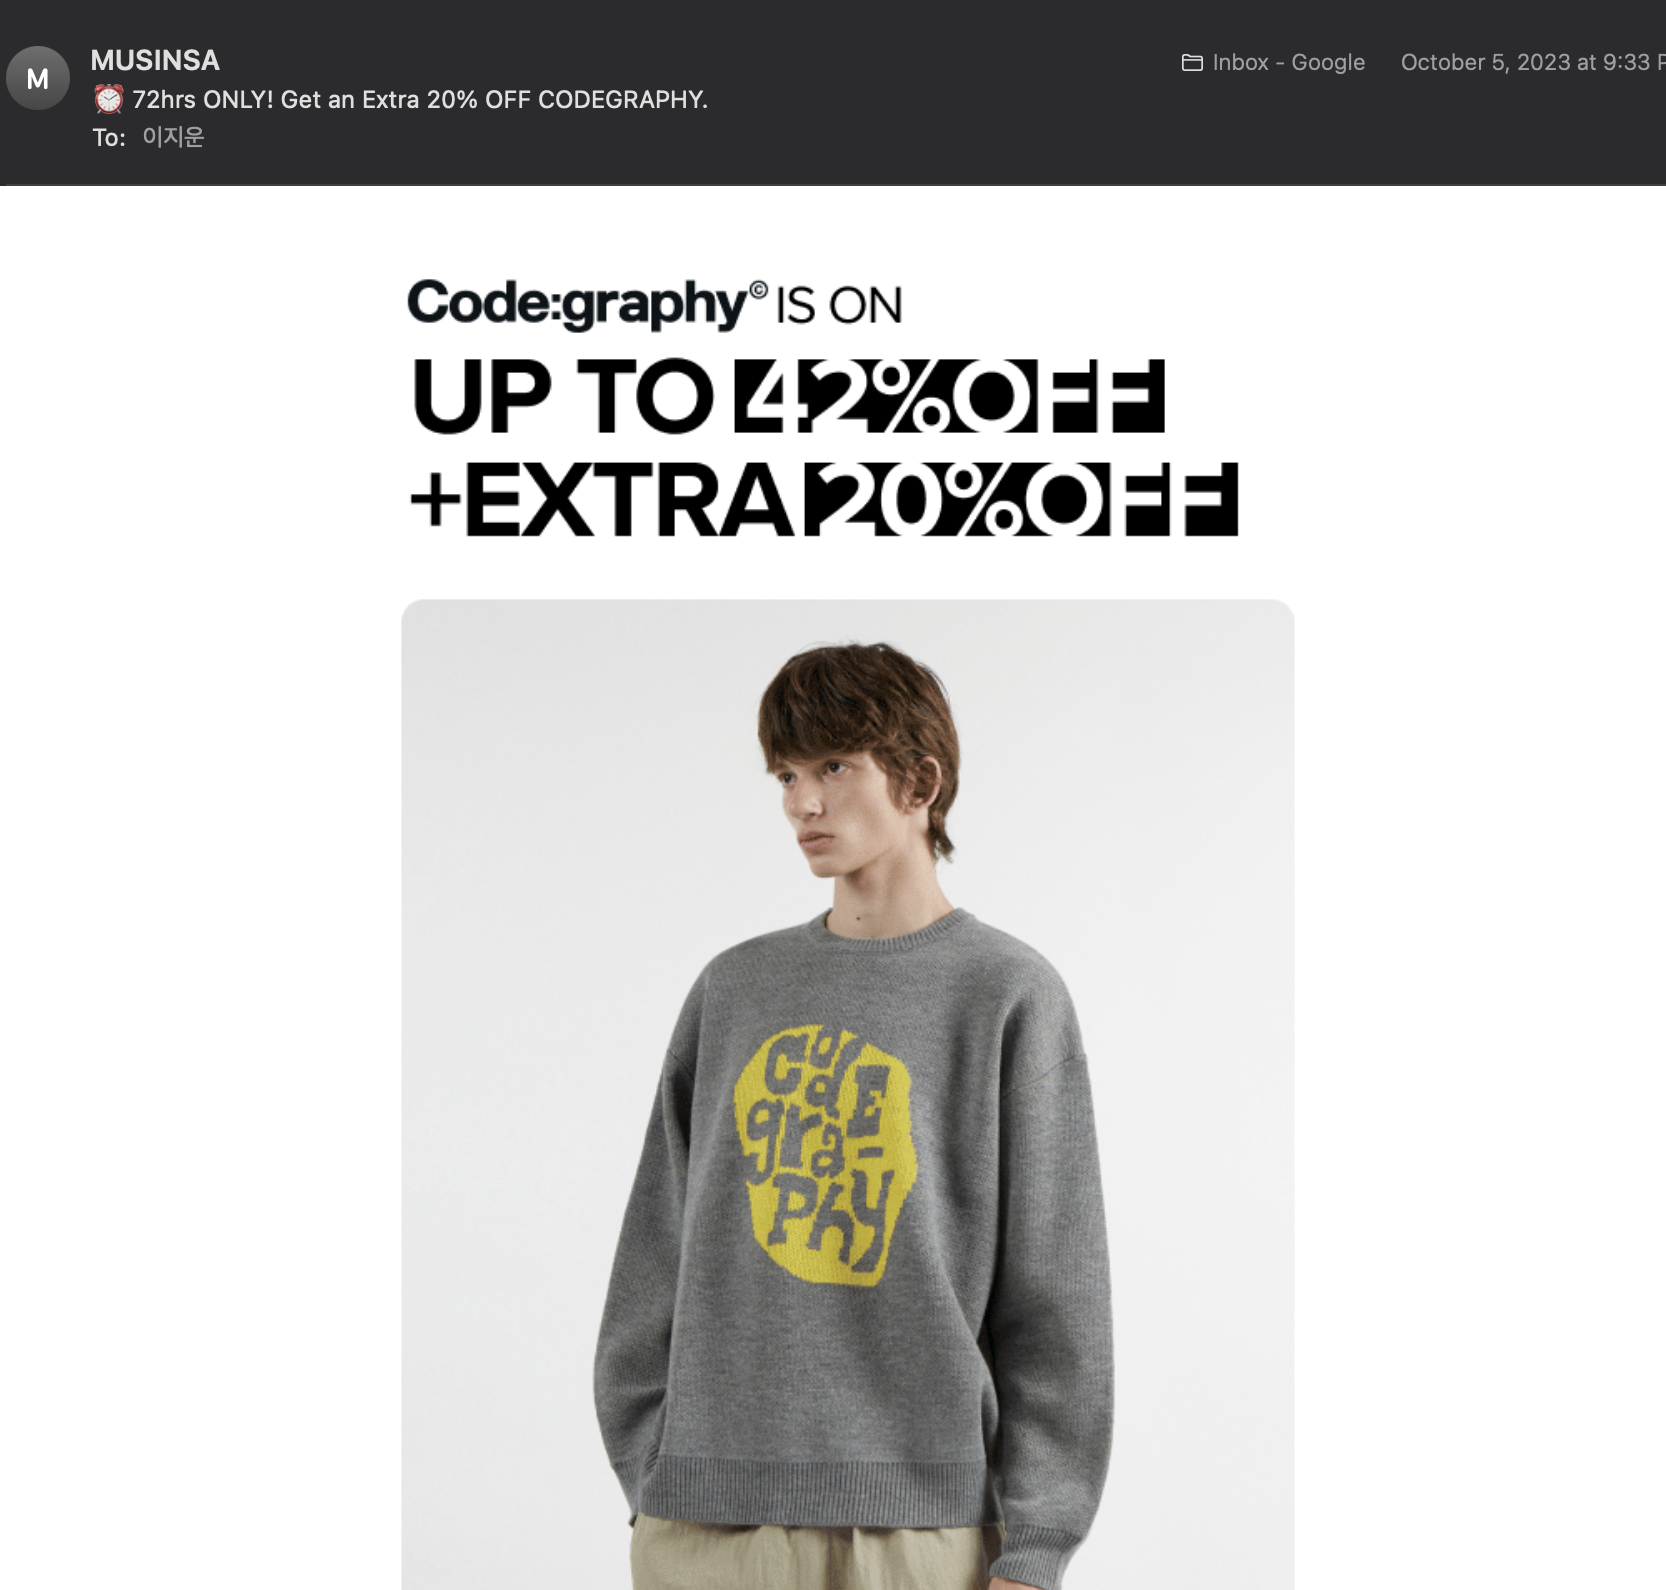

In [80]:
display(Image(filename='/Users/jiunlee/Desktop/Screenshot 2023-10-08 at 10.16.46 PM.png'))

I got This advertisement email from 'MUSINSA,' the online fashion platform in Korea. This notifies me that there's a sale on the brand 'Codegraphy.' I think this is a segmentation targeting a consumer with experience buying Codegraphy clothes. I've noticed that because I started getting this email after purchasing two shorts from Codegraphy. I don't usually get sales notifications from MUSINSA except for this brand.
 I am not sure if this advertisement is effective or not, because I haven't been really interested in their brand's sales, maybe because I wasn't happy with the last purchase. However, it might be effective for consumers who are satisfied with that brand. 